In [47]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet  # Facebook Prophet

from StockETL import GlobalPath

In [48]:
# Ignore harmless warnings
warnings.filterwarnings("ignore")

In [49]:
# Load and Prepare Data
holding_gold_file_path = GlobalPath(f"DATA/GOLD/Holding/{USERNAME}/Holding_data.csv")
df = pd.read_csv(holding_gold_file_path)

# Convert datetime column to date and process data
df["ds"] = pd.to_datetime(df["date"], errors="coerce")
df["y"] = pd.to_numeric(df["close_amount"], errors="coerce")
df = df.dropna(subset=["ds", "y"])
df = df[["ds", "y"]]
df = df.groupby("ds").sum().reset_index()
df = df.sort_values(by="ds").reset_index(drop=True)
df["ma52"] = df["y"].rolling(window=52).mean()
df.tail()

,ds,y,ma52
1767,2025-02-21,221500.98,223275.476538
1768,2025-02-22,221500.98,223111.314615
1769,2025-02-23,221500.98,222852.331923
1770,2025-02-24,221500.98,222548.705769
1771,2025-02-25,221500.98,222245.079615


In [50]:
# Initialize and Fit Prophet Model
model = Prophet()
model.fit(df)

# Create future dataframe for prediction
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
forecast.tail()

15:51:53 - cmdstanpy - INFO - Chain [1] start processing
15:51:53 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2132,2026-02-21,318919.629645,253131.032758,380678.442606,255445.840658,379324.539081,-1130.281719,-1130.281719,-1130.281719,-19.886064,-19.886064,-19.886064,-1110.395655,-1110.395655,-1110.395655,0.0,0.0,0.0,317789.347926
2133,2026-02-22,319153.842152,257367.557096,380010.453831,255133.708540,379877.348256,-1178.831443,-1178.831443,-1178.831443,-152.993065,-152.993065,-152.993065,-1025.838378,-1025.838378,-1025.838378,0.0,0.0,0.0,317975.010709
2134,2026-02-23,319388.054659,253980.857165,380785.046814,254821.576422,380430.157432,-1082.609692,-1082.609692,-1082.609692,-150.194752,-150.194752,-150.194752,-932.414940,-932.414940,-932.414940,0.0,0.0,0.0,318305.444967
2135,2026-02-24,319622.267166,254345.325146,381084.006422,254513.145291,380982.966608,-639.229376,-639.229376,-639.229376,194.412902,194.412902,194.412902,-833.642278,-833.642278,-833.642278,0.0,0.0,0.0,318983.037791
2136,2026-02-25,319856.479673,256463.506779,381054.048299,254472.842949,381535.775784,-733.461836,-733.461836,-733.461836,-0.068269,-0.068269,-0.068269,-733.393567,-733.393567,-733.393567,0.0,0.0,0.0,319123.017838


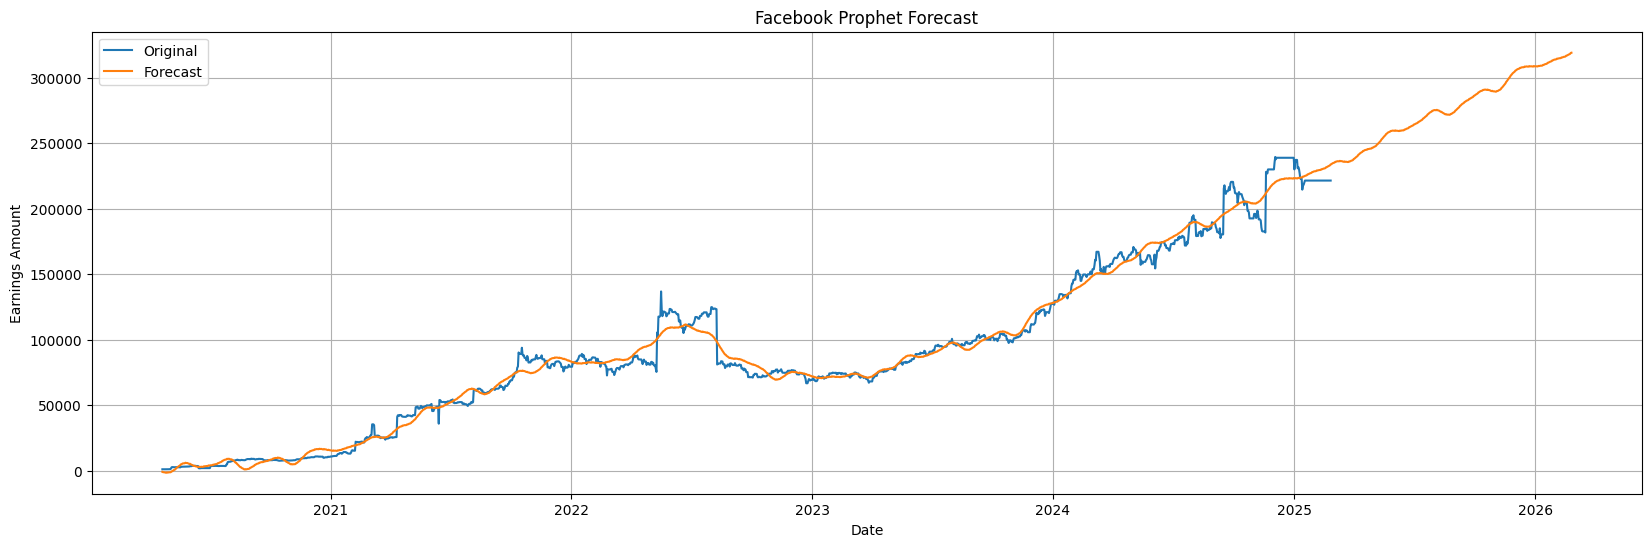

In [51]:
# Plot results
plt.figure(figsize=(20, 6))
plt.plot(df["ds"], df["y"], label="Original")
# plt.plot(df['ds'], df['ma52'], label='MA52')
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast")
plt.title("Facebook Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Earnings Amount")
plt.grid(True)
plt.legend()
plt.show()